# Recruitment Experiment

In developing lifelong learning algorithms, prior work has involved two main approaches: building and reallocating. Building involves adding new resources to support the arrival of new data, whereas reallocation involves compression of representations to make room for new ones. However, biologically, there is a spectrum between these two modes.

In order to examine whether current resources could be better leveraged, we test a range of approaches: **recruitment** of the best-performing existing trees, **building** new trees completely (the default approach used by lifelong classification forests), ignoring all prior trees (essentially an uncertainty forest), and a **hybrid** between building and recruitment.

This experiment examines the performance of these four approaches based on the available training sample size.

In [15]:
import numpy as np
import random
import tensorflow.keras as keras

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import functions.recruitment_functions as fn

**Note:** This notebook tutorial uses functions stored externally within `functions/recruitment_functions.py` to simplify presentation of code. These functions are imported above, along with other libraries.

### CIFAR-100 Dataset

The classification problem that we examine in this tutorial makes use of the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which is a labeled subset of the 80 million tiny images dataset. There are 100 classes ("fine" labels), containing 600 32x32-pixel images each (500 training and 100 testing). These 100 classes are grouped into 20 superclasses ("coarse" labels). Let's import the data:

In [2]:
# import data 
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

To give a quick overview of what these data look like, let's plot the first five images in the training dataset.

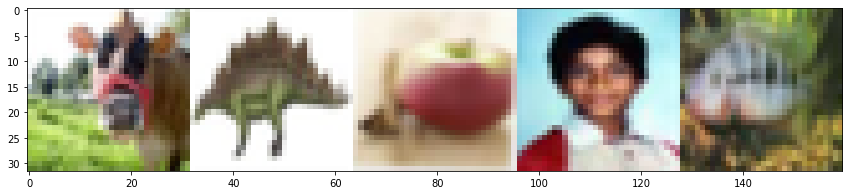

In [3]:
# plot example data
plt.figure(figsize=(15,3))
plt.imshow(np.hstack((X_train[0],X_train[1],X_train[2],X_train[3],X_train[4])))
plt.show()

### The Experiment

Now that we have imported the CIFAR 10x10 dataset, we can prepare to run the experiment. The function for running the experiment, `experiment`, can be found within `functions/recruitment_functions.py`.

We first declare the hyperparameters to be used for the experiment, which are as follows:
- `ntrees`: number of trees
- `reps`: number of repetitions to run the experiment for
- `estimation_set`: size of set used to train for 10th task, given as proportion (`1-estimation_set` is the size of the set used for validation, the selection of best trees)
- `num_points_per_task`: total number of points per run
- `num_points_per_forest`: number of points per forest (each training iteration/task)
- `task_10_sample`: number of samples to train on for the 10th task

In [4]:
############################
### Main hyperparameters ###
############################
ntrees = 50
#reps = 30
reps = 5
estimation_set = 0.63
num_points_per_task = 5000 
num_points_per_forest = 500 
task_10_sample = 10*np.array([10, 50, 100, 200, 350, 500])

Because the images are presented as 3D arrays, where the third dimension contains the values of the red, blue, and green channels, respectively, and are divided into training and testing sets of size 500 and 100, as mentioned earlier, we must do a little more preprocessing to get these data into a form suited for the progressive learner.

Here, we recombine the pre-established training and testing sets into one large dataset and reshape the arrays into a 1-dimensional string of numbers. We then call the `sort_data` command to divide the data into training and testing set for each task.

In [5]:
# reformat data
data_x = np.concatenate([X_train, X_test])
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

# sort data
train_x_across_task, train_y_across_task, test_x_across_task, test_y_across_task = fn.sort_data(data_x,data_y,num_points_per_task)

To replicate the experiment found in [Vogelstein, et al. (2020)](https://arxiv.org/pdf/2004.12908.pdf), we use the hyperparameter values established previously to train a lifelong forest on the first nine CIFAR 10x10 tasks, where we have `50` trees (`ntrees`) and `500` samples (`num_points_per_forest`) for each set.

For the 10th task, we use training sample sizes ranging from `100` to `5000` (`task_10_sample`) and obtain generalization errors for each of the following approaches:
1. **Building (default for lifelong forests)**, which involves training `ntrees=50` new trees,
2. **Uncertainty forest**, which ignores all prior trees,
3. **Recruiting**, which selects the `ntrees=50` (out of all 450 existing trees) that perform best on the newly introduced 10th task, and
4. **Hybrid**, which both builds `ntrees/2=25` new trees and recruits the `ntrees/2=25` best-performing trees.

Let's call our `experiment` function and give it a run!

In [6]:
# run the experiment
mean_acc_dict, std_acc_dict = fn.experiment(
    train_x_across_task, 
    train_y_across_task, 
    test_x_across_task, 
    test_y_across_task,
    ntrees, 
    reps, 
    estimation_set, 
    num_points_per_task,
    num_points_per_forest, 
    task_10_sample
)

# might want to recorder to return values in order of L2F (building), UF (new), recruiting, hybrid

doing 100 samples for 0 th rep
doing 100 samples for 1 th rep
doing 100 samples for 2 th rep
doing 100 samples for 3 th rep
doing 100 samples for 4 th rep
0.7032
0.6638
0.6912
0.7468
doing 500 samples for 0 th rep
doing 500 samples for 1 th rep
doing 500 samples for 2 th rep
doing 500 samples for 3 th rep
doing 500 samples for 4 th rep
0.5872
0.5661999999999999
0.6042
0.5936
doing 1000 samples for 0 th rep
doing 1000 samples for 1 th rep
doing 1000 samples for 2 th rep
doing 1000 samples for 3 th rep
doing 1000 samples for 4 th rep
0.5433999999999999
0.5306000000000001
0.5618000000000001
0.5529999999999999
doing 2000 samples for 0 th rep
doing 2000 samples for 1 th rep
doing 2000 samples for 2 th rep
doing 2000 samples for 3 th rep
doing 2000 samples for 4 th rep
0.505
0.4856
0.5264
0.505
doing 3500 samples for 0 th rep
doing 3500 samples for 1 th rep
doing 3500 samples for 2 th rep
doing 3500 samples for 3 th rep
doing 3500 samples for 4 th rep
0.49399999999999994
0.47779999999999995


As you can see from the code above, our `experiment` function returns two dictionaries,`mean_acc_dict` and `std_acc_dict`, that respectively contain the means and standard deviations of the generalization errors for each approach (building, UF, recruiting, hybrid) over all repetitions. The dictionary keys correspond to each approach.

### Visualizing the Results

Let's visualize the results of the experiment through the `recruitment_plot` function, which can be found in `functions/recruitment_functions.py`.

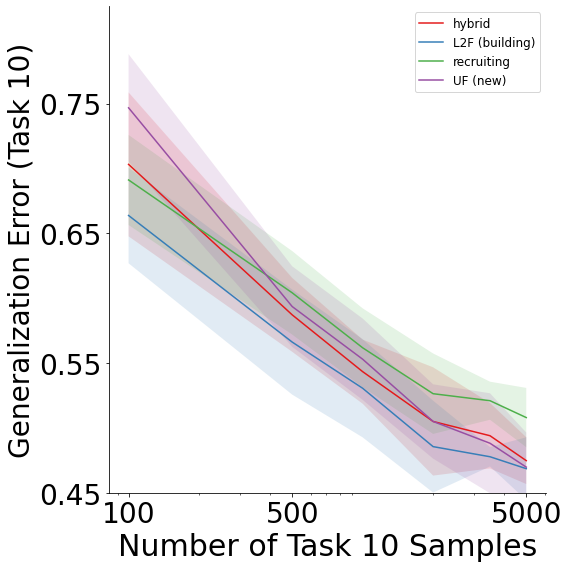

In [18]:
# plot results
fn.recruitment_plot(mean_acc_dict, std_acc_dict, task_10_sample)

From these results, we see that lifelong forests outperform all other approaches except at 5000 task 10 samples, which illustrate how relative performance depends on available resources and sample size.